In [20]:
import ilp_solver
from intuitive_algo_2 import intuitive_algo_2
from solution import Flags, Solution
from config import Config
from integer_linear_problem import Ilp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output
from tqdm import tqdm
import functools
from pprint import pprint
import warnings
import itertools
from IPython.display import display
import utils
from pathlib import Path

# ignore PuLP warning about spaces in filename path
warnings.filterwarnings('ignore', 'Spaces are not permitted in the name. Converted to*')

In [21]:
SMALL_ILP = Ilp.from_excel(Config().DATA_SMALL_PATH)
LARGE_ILP = Ilp.from_excel(Config().DATA_LARGE_PATH)

PRECOMP_RUNTIMES_GUROBI_SMALL = [0.26824630005285144, 0.27630030002910644, 0.3391844999277964, 0.4732870999723673, 0.7567533000838012, 1.5649043000303209, 3.0845806000288576, 5.9736562999896705, 12.078971900045872, 27.137739000027068]
PRECOMP_RUNTIMES_PULP_SMALL = [0.06085280003026128, 0.08504940010607243, 0.28308990004006773, 1.5874389000236988, 8.962808599928394, 27.591854800004512, 82.18447780003771]
PRECOMP_RUNTIMES_GUROBI_LARGE = [0.1858290999662131, 0.20222810003906488, 0.25675760000012815, 0.39813759992830455, 0.7294863000279292, 1.3755409000441432, 3.3761894999770448, 5.740992400096729, 8.55019069998525, 17.26968099991791, 26.9027660000138, 70.62542229995597, 198.566719800001, 919.544683199958, 3322.904872299987]
PRECOMP_RUNTIMES_PULP_LARGE = [0.06504960008896887, 0.07228169997688383, 0.25637399998959154, 2.090188800008036, 7.1632757999468595, 20.782907099928707, 83.19492479995824, 263.40518729999894, 1139.7699037999992, 12474.314908100001]

def get_ilp(n, ilp: Ilp):
    N = set(range(1, n + 1))
    w = pd.DataFrame.from_dict(ilp.w).iloc[:n, :n].to_dict()
    c = pd.DataFrame.from_dict(ilp.c).iloc[:n, :n].to_dict()
    f = pd.Series(ilp.f)[:n].to_dict()

    return Ilp(N, ilp.collection, ilp.transfer, ilp.distribution, w, c, f)

@functools.cache
def get_solve_time(n, solver_fn, target_ilp):
    if (PRECOMP_RUNTIMES_GUROBI_SMALL is not None and solver_fn is ilp_solver.gurobi_v1 and target_ilp is SMALL_ILP and n <= len(PRECOMP_RUNTIMES_GUROBI_SMALL)):
        return PRECOMP_RUNTIMES_GUROBI_SMALL[n - 1]
    if (PRECOMP_RUNTIMES_PULP_SMALL is not None and solver_fn is ilp_solver.pulp_v1 and target_ilp is SMALL_ILP and n <= len(PRECOMP_RUNTIMES_PULP_SMALL)):
        return PRECOMP_RUNTIMES_PULP_SMALL[n - 1]
    if (PRECOMP_RUNTIMES_GUROBI_LARGE is not None and solver_fn is ilp_solver.gurobi_v1 and target_ilp is LARGE_ILP and n <= len(PRECOMP_RUNTIMES_GUROBI_LARGE)):
        return PRECOMP_RUNTIMES_GUROBI_LARGE[n - 1]
    if (PRECOMP_RUNTIMES_PULP_LARGE is not None and solver_fn is ilp_solver.pulp_v1 and target_ilp is LARGE_ILP and n <= len(PRECOMP_RUNTIMES_PULP_LARGE)):
        return PRECOMP_RUNTIMES_PULP_LARGE[n - 1]
    
    ilp = get_ilp(n, target_ilp)
    sol: Solution = solver_fn(ilp, Flags.NONE)
    
    return sol.timer.end_time - sol.timer.start_time

c:\Users\Thom van den Hil\Desktop\Modelling-B\venv\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,2,3,4,5,6,7,8,9,10
n,,,,,,,,,
a,0.065050,0.035405,0.004463,0.037794,0.080833,0.026272,0.065947,0.012437,0.000007
b,1.111178,2.669028,7.764601,3.713175,3.035805,3.831145,3.270264,4.170650,10.655219


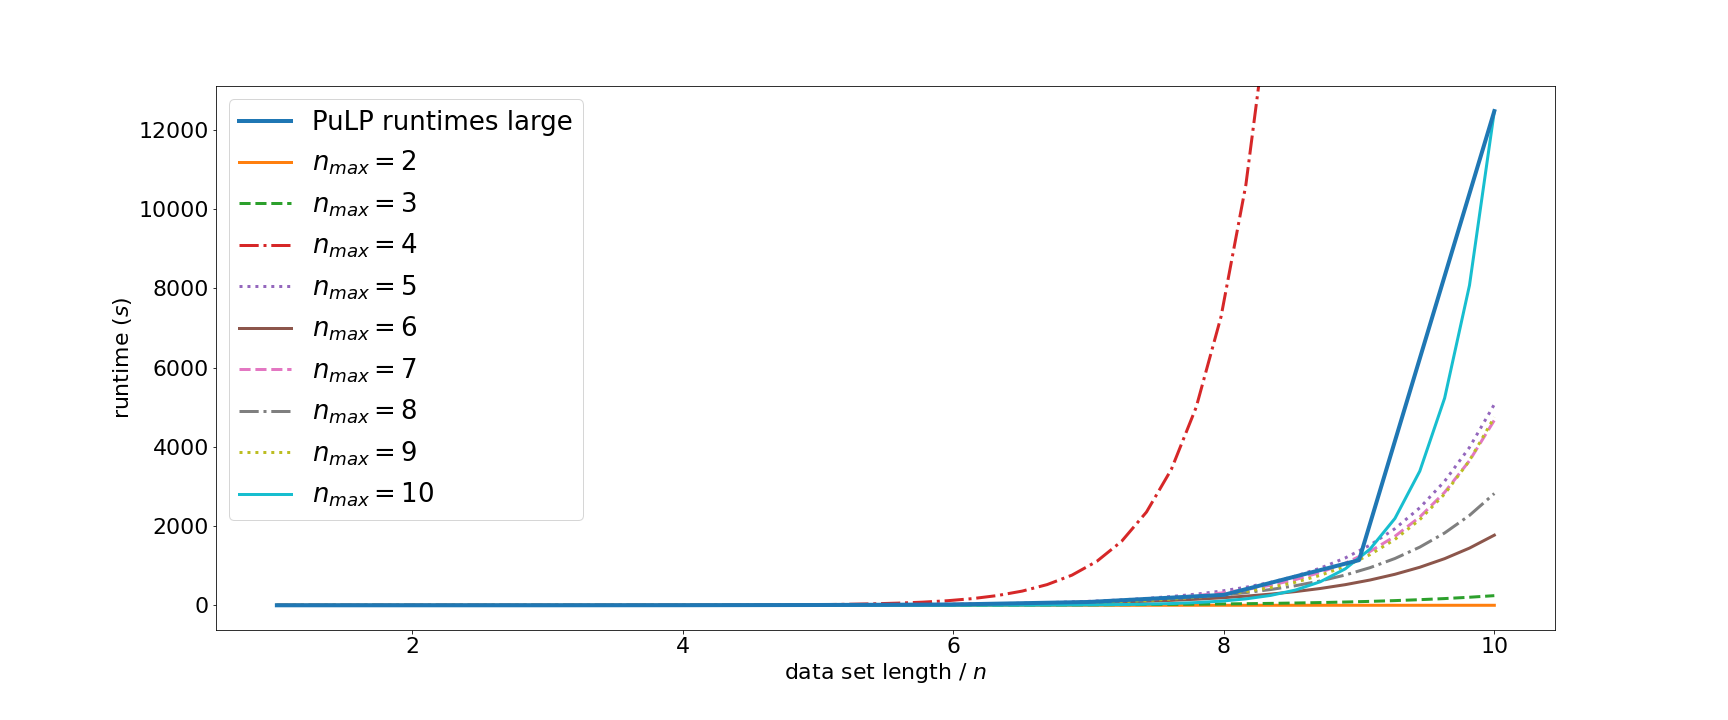

In [74]:
%matplotlib widget

plt.rcParams['figure.figsize'] = [24, 10]
plt.rcParams.update({'font.size': 22})
plt.xlabel(r'data set length / $n$')
plt.ylabel(r'runtime ($s$)')
LINEWIDTH = 3
LINEWIDTH_RUNTIMES = 4
FONTSIZE = 16

LINE_DASHES = ['-', '--', '-.', ':']

ALPHABET = list('abcdefghijklmnopqrstuvwxyz')

MIN_N_GUROBI_SMALL = 1
MAX_N_GUROBI_SMALL = 10

MIN_N_PULP_SMALL = 1
MAX_N_PULP_SMALL = 7

MIN_N_GUROBI_LARGE = 1
MAX_N_GUROBI_LARGE = 15

MIN_N_PULP_LARGE = 1
MAX_N_PULP_LARGE = 10

STEP = 1

# def objective(x, a, b, c, d, e):
#     return a + b * x**1 + c * x**2 + d * x**3 + e * x**4
def objective(x, a, b):
    return a * b ** (x - 1)

n_gurobi_small_arr = np.arange(MIN_N_GUROBI_SMALL, MAX_N_GUROBI_SMALL + 1)
runtimes_gurobi_small_arr = np.fromiter((get_solve_time(n, ilp_solver.gurobi_v1, SMALL_ILP) for n in range(MIN_N_GUROBI_SMALL, MAX_N_GUROBI_SMALL + 1)), float)

n_pulp_small_arr = np.arange(MIN_N_PULP_SMALL, MAX_N_PULP_SMALL + 1)
runtimes_pulp_small_arr = np.fromiter((get_solve_time(n, ilp_solver.pulp_v1, SMALL_ILP) for n in range(MIN_N_PULP_SMALL, MAX_N_PULP_SMALL + 1)), float)

n_gurobi_large_arr = np.arange(MIN_N_GUROBI_LARGE, MAX_N_GUROBI_LARGE + 1)
runtimes_gurobi_large_arr = np.fromiter((get_solve_time(n, ilp_solver.gurobi_v1, LARGE_ILP) for n in range(MIN_N_GUROBI_LARGE, MAX_N_GUROBI_LARGE + 1)), float)

n_pulp_large_arr = np.arange(MIN_N_PULP_LARGE, MAX_N_PULP_LARGE + 1)
runtimes_pulp_large_arr = np.fromiter((get_solve_time(n, ilp_solver.pulp_v1, LARGE_ILP) for n in range(MIN_N_PULP_LARGE, MAX_N_PULP_LARGE + 1)), float)


# # gurobi small
# line_cycler = itertools.cycle(LINE_DASHES)
# plt.plot(n_gurobi_small_arr, runtimes_gurobi_small_arr, label='Gurobi runtimes small', lw=LINEWIDTH_RUNTIMES)

# params_data_lst = []
# index_n = []
# max_measure_points = range(MIN_N_GUROBI_SMALL, MAX_N_GUROBI_SMALL + 1, STEP)
# # max_measure_points = [5, 6, 7, 8]
# for n in max_measure_points:
#     n_arr = n_gurobi_small_arr[:n - MIN_N_GUROBI_SMALL + 1]
#     runtimes_arr = runtimes_gurobi_small_arr[:n - MIN_N_GUROBI_SMALL + 1]

#     # func input vector length N must not exceed func output vector length M
#     try:
#         params, _ = curve_fit(objective, n_arr, runtimes_arr)
#     except TypeError:
#         continue

#     params_data_lst.append(params)
#     index_n.append(n)
#     # plt.plot(n_gurobi_small_arr, objective(n_gurobi_small_arr, *params), ls=next(line_cycler), label=fr'n_max = {n}')
#     # continuous_n_arr = np.linspace(MIN_N_GUROBI_SMALL, MAX_N_GUROBI_SMALL)
#     continuous_n_arr = np.linspace(1, 10)
#     plt.plot(continuous_n_arr, objective(continuous_n_arr, *params), ls=next(line_cycler), label=fr'$n_{{max}} = {n}$', lw=LINEWIDTH)
    
# params_df = pd.DataFrame(params_data_lst, index=index_n, columns=ALPHABET[:len(params)]).T
# params_df.index.name = 'n'
# display(params_df)
# plt.legend(fontsize=FONTSIZE)
# plt.show()


# # pulp small
# line_cycler = itertools.cycle(LINE_DASHES)
# plt.plot(n_pulp_small_arr, runtimes_pulp_small_arr, label='PuLP runtimes small', lw=LINEWIDTH_RUNTIMES)

# params_data_lst = []
# index_n = []
# max_measure_points = range(MIN_N_PULP_SMALL, MAX_N_PULP_SMALL + 1, STEP)
# # max_measure_points = [5, 6, 7, 8]
# for n in max_measure_points:
#     n_arr = n_pulp_small_arr[:n - MIN_N_PULP_SMALL + 1]
#     runtimes_arr = runtimes_pulp_small_arr[:n - MIN_N_PULP_SMALL + 1]

#     # func input vector length N must not exceed func output vector length M
#     try:
#         params, _ = curve_fit(objective, n_arr, runtimes_arr)
#     except TypeError:
#         continue

#     pulp_small_params = params
#     params_data_lst.append(params)
#     index_n.append(n)
#     # plt.plot(n_pulp_small_arr, objective(n_pulp_small_arr, *params), ls=next(line_cycler), label=fr'n_max = {n}')
#     continuous_n_arr = np.linspace(MIN_N_PULP_SMALL, MAX_N_PULP_SMALL)
#     # continuous_n_arr = np.linspace(1, 10)
#     plt.plot(continuous_n_arr, objective(continuous_n_arr, *params), ls=next(line_cycler), label=fr'$n_{{max}} = {n}$', lw=LINEWIDTH)
    
# params_df = pd.DataFrame(params_data_lst, index=index_n, columns=ALPHABET[:len(params)]).T
# params_df.index.name = 'n'
# display(params_df)
# plt.legend(fontsize=FONTSIZE)
# plt.show()


# # gurobi large
# line_cycler = itertools.cycle(LINE_DASHES)
# plt.plot(n_gurobi_large_arr, runtimes_gurobi_large_arr, label='Gurobi runtimes large', lw=LINEWIDTH_RUNTIMES)

# params_data_lst = []
# index_n = []
# max_measure_points = range(MIN_N_GUROBI_LARGE, MAX_N_GUROBI_LARGE + 1, STEP)
# # max_measure_points = [5, 6, 7, 8]
# for n in max_measure_points:
#     # if n == 2:
#     #     continue

#     n_arr = n_gurobi_large_arr[:n - MIN_N_GUROBI_LARGE + 1]
#     runtimes_arr = runtimes_gurobi_large_arr[:n - MIN_N_GUROBI_LARGE + 1]

#     # func input vector length N must not exceed func output vector length M
#     try:
#         params, _ = curve_fit(objective, n_arr, runtimes_arr)
#     except TypeError:
#         continue

#     params_data_lst.append(params)
#     index_n.append(n)
#     # plt.plot(n_gurobi_large_arr, objective(n_gurobi_large_arr, *params), ls=next(line_cycler), label=fr'n_max = {n}')
#     continuous_n_arr = np.linspace(MIN_N_GUROBI_LARGE, MAX_N_GUROBI_LARGE)
#     plt.plot(continuous_n_arr, objective(continuous_n_arr, *params), ls=next(line_cycler), label=fr'$n_{{max}} = {n}$', lw=LINEWIDTH)
    
# params_df = pd.DataFrame(params_data_lst, index=index_n, columns=ALPHABET[:len(params)]).T
# params_df.index.name = 'n'
# display(params_df)
# plt.legend(fontsize=FONTSIZE)
# plt.show()


# PuLP large
line_cycler = itertools.cycle(LINE_DASHES)
plt.plot(n_pulp_large_arr, runtimes_pulp_large_arr, label='PuLP runtimes large', lw=LINEWIDTH_RUNTIMES, zorder=999)

params_data_lst = []
index_n = []
max_measure_points = range(MIN_N_PULP_LARGE, MAX_N_PULP_LARGE + 1, STEP)
# max_measure_points = filter(lambda x: x != 4, max_measure_points)
for n in max_measure_points:
    n_arr = n_pulp_large_arr[:n - MIN_N_PULP_LARGE + 1]
    runtimes_arr = runtimes_pulp_large_arr[:n - MIN_N_PULP_LARGE + 1]

    # func input vector length N must not exceed func output vector length M
    try:
        params, _ = curve_fit(objective, n_arr, runtimes_arr)
    except TypeError:
        continue

    pulp_large_params = params
    params_data_lst.append(params)
    index_n.append(n)
    # plt.plot(n_pulp_large_arr, objective(n_pulp_large_arr, *params), ls=next(line_cycler), label=fr'n_max = {n}')
    # continuous_n_arr = np.linspace(MIN_N_PULP_LARGE, MAX_N_PULP_LARGE)
    continuous_n_arr = np.linspace(1, 10)
    plt.plot(continuous_n_arr, objective(continuous_n_arr, *params), ls=next(line_cycler), label=fr'$n_{{max}} = {n}$', lw=LINEWIDTH)
    
params_df = pd.DataFrame(params_data_lst, index=index_n, columns=ALPHABET[:len(params)]).T
params_df.index.name = 'n'
display(params_df)
plt.legend(fontsize=26)
x1, x2, y1, y2 = plt.axis()  
plt.axis((x1, x2, -623.7157380073593, 13098.030653152733))
plt.show()
    




In [55]:
utils.ensure_dir_exists(Path(r'out/figures/'))
plt.savefig(r'out/figures/runtimes_pulp_large.svg', bbox_inches='tight')

In [23]:
print(list(runtimes_gurobi_small_arr))
print(list(runtimes_pulp_small_arr))
print(list(runtimes_gurobi_large_arr))
print(list(runtimes_pulp_large_arr))

[0.26824630005285144, 0.27630030002910644, 0.3391844999277964, 0.4732870999723673, 0.7567533000838012, 1.5649043000303209, 3.0845806000288576, 5.9736562999896705, 12.078971900045872, 27.137739000027068]
[0.06085280003026128, 0.08504940010607243, 0.28308990004006773, 1.5874389000236988, 8.962808599928394, 27.591854800004512, 82.18447780003771]
[0.1858290999662131, 0.20222810003906488, 0.25675760000012815, 0.39813759992830455, 0.7294863000279292, 1.3755409000441432, 3.3761894999770448, 5.740992400096729, 8.55019069998525, 17.26968099991791, 26.9027660000138, 70.62542229995597, 198.566719800001, 919.544683199958, 3322.904872299987]
[0.06504960008896887, 0.07228169997688383, 0.25637399998959154, 2.090188800008036, 7.1632757999468595, 20.782907099928707, 83.19492479995824, 263.40518729999894, 1139.7699037999992, 12474.314908100001]


In [73]:
def objective(x, a, b):
    return a * b ** (x - 1)
a, b = params_df[10]
n = 15
print(objective(n, a, b) / (3600 * 24 * 365))
print(objective(n, a, b))

54.3213408139317
1713077803.90815


In [63]:
def objective(x, a, b):
    return a * b ** (x - 1)
for n_max in range(2, 10):
    a, b = params_df[n_max]
    n = 10
    print(f'n_max -> {objective(n, a, b)}')

n_max -> 0.1679957036276195
n_max -> 243.35418217626548
n_max -> 457843.4218374239
n_max -> 5071.495459526392
n_max -> 1770.317193767077
n_max -> 4671.36229242327
n_max -> 2821.2541990523023
n_max -> 4748.5860855988585


243, 457843, 5071, 1770, 4671, 2821, 4749, 

In [71]:
print(' & '.join(list(map(lambda x: f'{x:.6f}', params_df.iloc[1]))))

1.111178 & 2.669028 & 7.764601 & 3.713175 & 3.035805 & 3.831145 & 3.270264 & 4.170650 & 10.655219
